In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
words = open('names.txt', 'r').read().splitlines()

In [14]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [ ]:
'''
# Three inputs embedded in a 2D space are fed to tanh as the hidden layer and softmax'd
# X is our vocabulary of block_size tokens
C[X] ->
C[X] -> tanh -> softmax
C[X] ->
'''

In [15]:
block_size = 3 # context length; how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [16]:
C = torch.randn((27,2)) # embedding, 27 chars to 2D space

In [23]:
emb = C[X]

In [25]:
W1 = torch.randn((6,100)) # tanh step, 6 inputs come from C * 3 (which have 2 outputs)
b1 = torch.randn(100) # biases middle layer

In [26]:
# torch.cat(emb[:, 0, :],emb[:, 1, :],emb[:, 2, :],1)
# torch.cat(torch.unbind(emb, 1)) # cat is slow
# emb.view(32,6) <- fastest
# emb.view(emb.shape[0], 6) @ W1 + b1
emb.view(-1, 6) @ W1 + b1

tensor([[ 1.3262,  1.8585,  0.6029,  ...,  1.3953,  0.7673, -1.2895],
        [ 2.2806,  2.4639, -0.2559,  ...,  2.5425,  1.5950, -1.7512],
        [ 0.5651,  0.8068,  1.2087,  ..., -4.3626, -1.8397, -2.6817],
        ...,
        [ 4.6168,  1.6199,  1.7261,  ..., -1.8739,  1.0311, -0.2740],
        [-3.2889,  0.7327,  0.9379,  ..., -2.2243, -2.7373,  3.8506],
        [ 2.7380, -4.6509,  3.7723,  ...,  0.9586,  3.3202,  0.4409]])

In [28]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # careful about broadcasting the + b1

In [29]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [30]:
logits = h @ W2 + b2

In [32]:
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [36]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.9938)

In [128]:
## Cleaned up

def build_dataset(words):
    block_size = 3 # context length; how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [129]:
embedding_size = 30
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((embedding_size,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [130]:
for p in parameters:
    p.requires_grad = True

In [131]:
lossi = []
stepi = []

In [140]:
for i in range(50000):

    # construct batch
    ix = torch.randint(0, Xtr.shape[0],(32,))
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, embedding_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    #stats
    stepi.append(i)
    lossi.append(loss.log10().item())


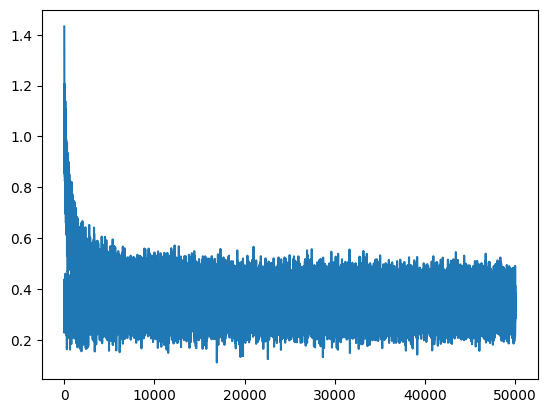

In [141]:
plt.plot(stepi, lossi)

In [142]:
# full model loss (training)
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.170982599258423


In [143]:
# full model loss (dev), if training and dev losses are similar the model is too simple
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2156341075897217


In [144]:
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, embedding_size) @ W1 + b1) # (32, 100)
        logits = h @ W2 + b2 # (32, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+ [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

gostyn.
povahnadiya.
emmilan.
reya.
zolin.
ashik.
pranhanton.
ale.
alechandy.
kayden.
aire.
jordie.
niu.
enna.
kocha.
tyhcti.
kyn.
divian.
dell.
ceari.


In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%